In [1]:
import os
import sys
import time
from pathlib import Path

BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')

sys.path.insert(0, SRC_DIR)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch

from sample.reader import VideoReader

In [3]:
!ls $DATA_DIR

dfdc_train_part_0  dfdc_train_part_1


In [4]:
def imshow(img, boxes=None, figsize=(15,8)):
    plt.figure(figsize=figsize)
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            text = plt.text(
                x=bbox[2]+10, 
                y=bbox[1]-10, 
                text=str(bbox[4]))
            plt.gca().add_patch(rect)
            plt.gca().add_patch(text)
    plt.imshow(img)


def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [5]:
def read_labels(base_path):
    if not os.path.isdir(base_path):
        raise ValueError('Invalid data dir')
    chunk_dirs = os.listdir(base_path)
    labels = []
    for dir_name in chunk_dirs:
        path = os.path.join(base_path, dir_name, 'metadata.json')
        df = pd.read_json(path).T
        df['dir'] = dir_name
        df['label'] = (df['label'] == 'FAKE').astype(np.uint8)
        labels.append(df)
    return pd.concat(labels)

In [6]:
df = read_labels(DATA_DIR)
print(df.shape)
df.head()

(3033, 4)


,label,split,original,dir
owxbbpjpch.mp4,1,train,wynotylpnm.mp4,dfdc_train_part_0
vpmyeepbep.mp4,0,train,NaN,dfdc_train_part_0
fzvpbrzssi.mp4,0,train,NaN,dfdc_train_part_0
htorvhbcae.mp4,1,train,wclvkepakb.mp4,dfdc_train_part_0
fckxaqjbxk.mp4,1,train,vpmyeepbep.mp4,dfdc_train_part_0


In [7]:
reader = VideoReader()

In [8]:
def get_sample(idx, labels_df, reader, n_frames=10, base_dir=DATA_DIR):
    row = labels_df.iloc[idx]
    file_path = os.path.join(base_dir, row.dir, row.name)
    sample, frames = reader.read_frames(file_path, n_frames)
    return sample

In [9]:
i = 3
sample = get_sample(i, df, reader)

In [10]:
sample.shape

(10, 1920, 1080, 3)

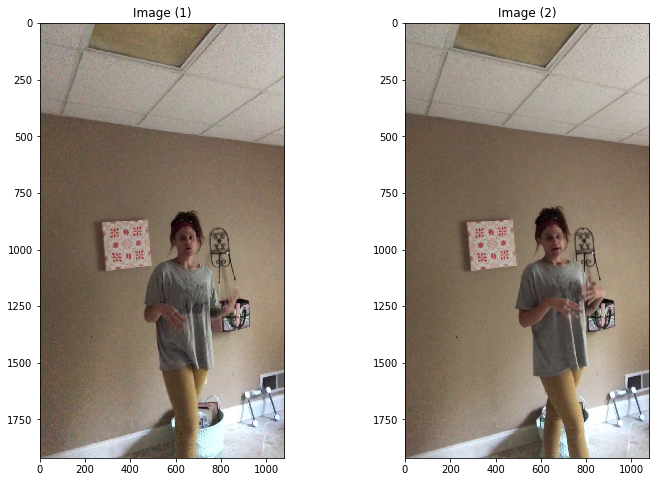

In [11]:
show_images(sample[:2])

In [12]:
sys.path.insert(0, os.path.join(BASE_DIR, 'Pytorch_Retinaface'))

In [13]:
from data import cfg_mnet
from layers.functions.prior_box import PriorBox
from models.retinaface import RetinaFace
from utils.box_utils import decode
from utils.nms.py_cpu_nms import py_cpu_nms

In [14]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [15]:
rface_weights = os.path.join(BASE_DIR, 'data/weights/mobilenet0.25_Final.pth')
use_cpu = False
confidence_threshold = 0.2
nms_threshold = 0.4
top_k = 5000
keep_top_k = 750

cfg = cfg_mnet
cfg['pretrain'] = False

net = RetinaFace(cfg=cfg, phase='test')
net = load_model(net, rface_weights, use_cpu)
net.eval()

Loading pretrained model from /home/dmitry/projects/dfdc/data/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


RetinaFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, e

In [16]:
device = torch.device("cpu" if use_cpu else "cuda")
net = net.to(device)

In [17]:
resize = 1
image_path = "./curve/test.jpg"
img_raw = sample[0] # cv2.imread(image_path, cv2.IMREAD_COLOR)
img = np.float32(img_raw)

im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
img -= (104, 117, 123)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).unsqueeze(0)
img = img.to(device)
scale = scale.to(device)

tic = time.time()
loc, conf, landms = net(img)  # forward pass
print('net forward time: {:.4f}'.format(time.time() - tic))

net forward time: 0.1448


In [18]:
priorbox = PriorBox(cfg, image_size=(im_height, im_width))
priors = priorbox.forward()
priors = priors.to(device)
prior_data = priors.data
boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
boxes = boxes * scale / resize
boxes = boxes.cpu().numpy()
scores = conf.squeeze(0).data.cpu().numpy()[:, 1]

# ignore low scores
inds = np.where(scores > confidence_threshold)[0]
boxes = boxes[inds]
scores = scores[inds]

# keep top-K before NMS
order = scores.argsort()[::-1][:top_k]
boxes = boxes[order]
scores = scores[order]

# do NMS
dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
keep = py_cpu_nms(dets, nms_threshold)
dets = dets[keep, :]

# keep top-K faster NMS
dets = dets[:keep_top_k, :]

In [19]:
def imshow(img, boxes=None, figsize=(15,8)):
    plt.figure(figsize=figsize)
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            if len(bbox) > 4:
                text = plt.text(
                    bbox[2]+10, bbox[1]-10, 
                    '%.02f' % bbox[4])
            plt.gca().add_patch(rect)
    plt.imshow(img)

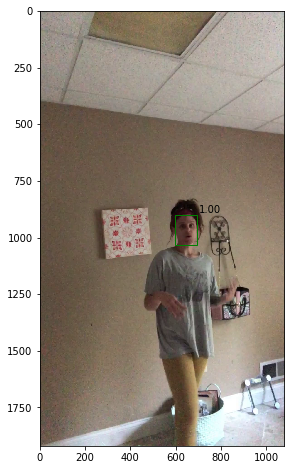

In [20]:
imshow(img_raw, boxes=dets)